In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os
import shutil

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from utils.show_grid import show_grid
from utils.augment import CutMix
from train import train_model
from utils.freeze import freezeParams, unfreezeParams, count_parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [3]:
EPOCHS = 5

In [4]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Augmentations

In [5]:
from dataset import PersonRobotDataset

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the value for the split are found manually to have 150 pictures of each class in training
dataset = PersonRobotDataset("data/images", train_ratio=.837, train_transform=data_transforms['train'], val_transform=data_transforms['val'])

cutmix_transform = CutMix()
train_loader = dataset.train_dataloader(collate_fn=cutmix_transform)
val_loader = dataset.val_dataloader()

Training set size: 300 images
Validation set size: 60 images


/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


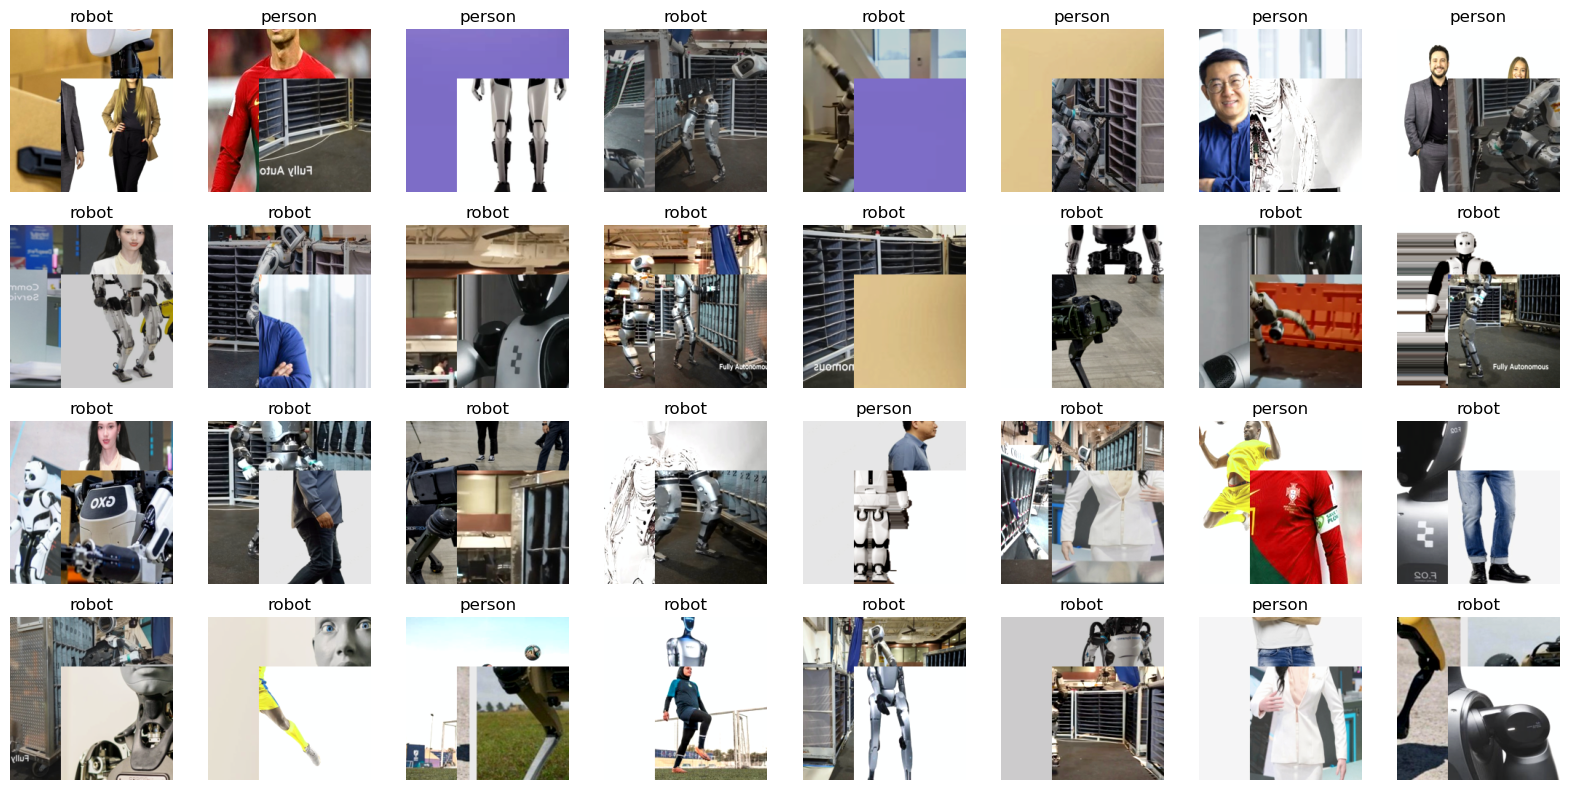

In [5]:
class_names = dataset.train_dataset.dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[1-int(x <= 0.5)] for x in classes]        
show_grid(inputs, titles)

In [6]:
inputs[10].size()

torch.Size([3, 224, 224])

## Training

In [7]:
from utils.seed import set_random_seed

set_random_seed()

### ResNet

In [8]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [20]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_tuned2")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:19,  2.18s/it]

Epoch 1/10
    Train loss: 0.41388
    Valid loss: 0.0742
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:04<00:17,  2.21s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:06<00:15,  2.23s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.35884
    Valid loss: 0.07479
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:15<00:06,  2.20s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:17<00:04,  2.17s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 10/10
    Train loss: 0.37252
    Valid loss: 0.07487
    Accuracy: 100.0%


Training completed


### ConvNext

In [22]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ConvNext_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [23]:
convnext_model = models.convnext_tiny(pretrained=True)
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, 1)
convnext_model.to(device)
print(convnext_model.classifier)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1, bias=True)
)


In [24]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:23,  2.61s/it]

Epoch 1/10
    Train loss: 0.51842
    Valid loss: 0.78622
    Accuracy: 35.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:05<00:20,  2.62s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:07<00:18,  2.65s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.22134
    Valid loss: 0.04906
    Accuracy: 98.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:18<00:08,  2.74s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:21<00:05,  2.65s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 9/10 [00:23<00:02,  2.62s/it]/home/user/kellerv1/miniforge3/envs/lab/li

Epoch 10/10
    Train loss: 0.28901
    Valid loss: 0.05141
    Accuracy: 98.33333333333333%


Training completed


### EfficientNet

In [26]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "EfficientNet_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [27]:
efficient_model = models.efficientnet_b0(pretrained=True)
num_ftrs = efficient_model.classifier[1].in_features
efficient_model.classifier[1] = nn.Linear(num_ftrs, 1)
efficient_model.to(device)
print(efficient_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)


In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:22,  2.49s/it]

Epoch 1/10
    Train loss: 0.64619
    Valid loss: 0.72255
    Accuracy: 38.333333333333336%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:05<00:20,  2.52s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:07<00:17,  2.49s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.40818
    Valid loss: 0.11564
    Accuracy: 100.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:16<00:06,  2.29s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:18<00:04,  2.35s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 10/10
    Train loss: 0.35061
    Valid loss: 0.10428
    Accuracy: 100.0%


Training completed


## Models as a fixed feature extractor

### ResNet

In [48]:
resnet_model = models.resnet18(pretrained=True)
freezeParams(resnet_model)

resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

count_parameters(resnet_model)

Total parameters: 11,308,097, trainable: 131,585


In [49]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [50]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [51]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/5 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

Epoch 1/5
    Train loss: 0.66811
    Valid loss: 0.68425
    Accuracy: 50.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████      | 2/5 [00:04<00:06,  2.28s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: Us

Epoch 5/5
    Train loss: 0.50409
    Valid loss: 0.34611
    Accuracy: 98.33333333333333%


Training completed


### ConvNext

In [52]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ConvNext_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [53]:
convnext_model = models.convnext_tiny(pretrained=True)
freezeParams(convnext_model)
num_ftrs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_ftrs, 1)
convnext_model.to(device)

count_parameters(convnext_model)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 27,820,897, trainable: 769


In [54]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [55]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=convnext_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:20,  2.33s/it]

Epoch 1/10
    Train loss: 0.74285
    Valid loss: 0.7945
    Accuracy: 45.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:04<00:18,  2.33s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:06<00:16,  2.33s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.64018
    Valid loss: 0.58921
    Accuracy: 80.0%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:16<00:07,  2.46s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:19<00:04,  2.39s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 10/10
    Train loss: 0.62216
    Valid loss: 0.55084
    Accuracy: 86.66666666666667%


Training completed


### EfficientNet

In [56]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "EfficientNet_fixed")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [57]:
efficient_model = models.efficientnet_b0(pretrained=True)
freezeParams(efficient_model)

num_ftrs = efficient_model.classifier[1].in_features
efficient_model.classifier[1] = nn.Linear(num_ftrs, 1)
efficient_model.to(device)

count_parameters(efficient_model)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 4,008,829, trainable: 1,281


In [58]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [59]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=efficient_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=2*EPOCHS, device=device, logger=writer.add_scalar
    )

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 1/10 [00:02<00:20,  2.28s/it]

Epoch 1/10
    Train loss: 0.67915
    Valid loss: 0.69419
    Accuracy: 53.333333333333336%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 2/10 [00:04<00:18,  2.30s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 30%|███       | 3/10 [00:07<00:16,  2.36s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: 

Epoch 6/10
    Train loss: 0.64949
    Valid loss: 0.59485
    Accuracy: 88.33333333333333%




/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 70%|███████   | 7/10 [00:15<00:06,  2.15s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 8/10 [00:17<00:04,  2.18s/it]/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 9/10 [00:20<00:02,  2.22s/it]/home/user/kellerv1/miniforge3/envs/lab/li

Epoch 10/10
    Train loss: 0.64525
    Valid loss: 0.57419
    Accuracy: 91.66666666666666%


Training completed


## Models with a Combined Approach

### ResNet

### ConvNext

### EfficientNet